In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import concurrent.futures
import timeit
from typing import Callable, List, Optional, Tuple
from functools import partial
import copy
from itertools import groupby
import sys, os
from scipy.optimize import minimize
from scipy.spatial.distance import (
    cosine
)

from data_loader import load_grid_search_data

plt.rcParams['figure.figsize'] = (15.0, 8.0)

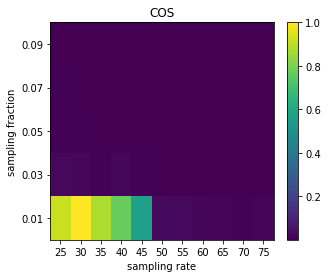

In [3]:
def heatmap_sf_sr_recon_error(sf_range, sr_range, errors):
    fig = plt.figure(figsize=[5, 4])
    plt.rc('font', size=10)
    
    # plt.plot()
    ax = plt.axes()
    # plt.plot(beta_opt, gamma_opt, "ro")

    X, Y = np.meshgrid(sr_range, sf_range, indexing='ij')
    Z = errors.reshape(len(sr_range), len(sf_range))

    c = ax.pcolormesh(X, Y, Z) # , cmap='viridis', vmin=z_min, vmax=z_max)
    # ax.axis([X.min(), X.max(), Y.min(), Y.max()])

    ax.set_xlabel("sampling rate")
    ax.set_xticks(sr_range)
    ax.set_ylabel("sampling fraction")
    ax.set_yticks(sf_range)
    ax.set_title("COS")
    # ax.plot(beta_opt, gamma_opt, "ro")
    fig.colorbar(c, ax=ax)
    # fig.savefig(figpath)
    plt.show()
    
mse = [2.118698600320954, 0.4264235441805948, 0.23822630844099071, 0.20689894933684855, 0.08179201689773634, 2.2506459599867297, 0.4361775598188958, 0.28659993733247136, 0.08744856847992419, 0.0732864746349093, 2.167304785566338, 0.2582870914352997, 0.07478826860249567, 0.08504810899867897, 0.027660263129608294, 2.0826489226719773, 0.4974349673297324, 0.10023255899534426, 0.043216215279435435, 0.012896733064577717, 1.890956325776356, 0.245688530621947, 0.1642245597373079, 0.04092778340638934, 0.009768291372807237, 0.6236907857945042, 0.07233869787634145, 0.04904438203387639, 0.006495148753355689, 0.004773276637086853, 0.45381613699741424, 0.09717807985892747, 0.020318993450127804, 0.0048653611344645215, 0.005854854988494881, 0.4079406685982311, 0.05752508146084986, 0.03293372173454906, 0.005337024286452811, 0.0016303156632120727, 0.32382769815856427, 0.04637524040669229, 0.007910584000797893, 0.011292997260871044, 0.0020378982544017655, 0.2728995121818533, 0.034334197749544375, 0.0279716691639176, 0.013906723654300636, 0.001582039421033094, 0.2951727273794584, 0.024794543470055355, 0.004180796621427102, 0.009449785715426139, 0.0011158319481410295]
cos = [0.9170881306593054, 0.020395174146597972, 0.00566981610523154, 0.0039384215167377334, 0.0007302953545714752, 1.0004203497002622, 0.0188219007392203, 0.007393527964160818, 0.0008502044459147706, 0.0005899466741239312, 0.8769843605026652, 0.006205772549262689, 0.0005508984920948867, 0.0007414948727852977, 7.253485673319737e-05, 0.7693052304633172, 0.01950434449772509, 0.001064726690196749, 0.0002024321084277414, 1.8883842521799643e-05, 0.5646786756984006, 0.006642873884647016, 0.0029412072261973954, 0.00018737105799071507, 1.0644817274751972e-05, 0.027019925328360506, 0.0005010397101369302, 0.00026940280691556406, 4.361747626302481e-06, 2.5351871332235376e-06, 0.021951737749359213, 0.0008852483031792646, 3.9699370302459513e-05, 2.5529419176439916e-06, 3.841655672132127e-06, 0.012003482167032176, 0.00033436962588717645, 0.00011804230235890056, 3.15399044503728e-06, 2.913723184949646e-07, 0.00905803211426015, 0.00022103601155998298, 6.564199006353633e-06, 1.4181103266008854e-05, 4.6520245389203296e-07, 0.005834684113153243, 0.0001240059951487238, 8.686624768983187e-05, 2.1601343854538158e-05, 2.750607249746295e-07, 0.008060298714766545, 5.8996589237358954e-05, 1.900175701008422e-06, 1.0013390652097165e-05, 1.3908894402892003e-07]

sr_range = range(25, 76, 5)
sf_range = np.arange(0.01, 0.11, 0.02)
heatmap_sf_sr_recon_error(sf_range, sr_range, np.array(cos))
# heatmap_sf_sr_recon_error(sf_range, sr_range, np.array(mse))
    

In [77]:
def vis_recon_error(ax, nq_range, inst_range, sf_range, errors, plot_type, title: str, start: int=1):
    errors = errors.reshape(len(nq_range), len(inst_range), len(sf_range))

    
    print("shape before transpose: ", errors.shape)
    # print(errors)
    errors = errors.transpose(0, 2, 1)
    print("shape after transpose: ", errors.shape)

    # fig, axes = plt.subplots(1, 2, figsize=(9, 5))
    # plt.plot()

    # iax = 0
    
    # ax = plt.axes()
    for i in range(len(nq_range)):
        if plot_type == 'box':
            ax.boxplot(errors[0])

        elif plot_type == 'quantiles':
            y = errors[i, start:] # shape = (len(sf_range), len(inst_range))
            y = np.nanquantile(y, q=(0.25, 0.5, 0.75), axis=1) 
            # print(y)
            x = np.array(sf_range[start:])
            # x = np.range(len(sf_range[start:]))
            # print(x)
            label = f"{nq_range[i]} qubits"
            fmt = "" 
            ax.errorbar( 
                x,
                # y[1][x],
                y[1], 
                # yerr=(y[1][x] - y[0][x], y[2][x] - y[1][x]), 
                yerr=(y[1] - y[0], y[2] - y[1]), 
                label=label, 
                alpha=0.75, 
                fmt=fmt, 
                capsize=3, 
                capthick=1, 
            ) 
            # plt.fill_between(x, y1=y[0][x], y2=y[2][x], alpha=0.25)
            ax.fill_between(x, y1=y[0], y2=y[2], alpha=0.25)
        elif plot_type == 'line':
            ax.plot(sf_range[start:],
                errors[i,start:,:].mean(axis=-1),
                label=f"{nq_range[i]} qubits")
        else:
            raise NotImplementedError()

    ax.set_xlabel("sampling fraction")
    ax.set_ylabel("NRMSE")
    ax.set_title(title)
    # ax.legend()
    # plt.show()
    return


def vis_maxcut(ax, p: int, noise: str, error_type: str):
    
    if p == 1 and noise == 'ideal':
        recon_error_data = np.load(
            "figs/grid_search_recon/maxcut/sv-ideal-p=1/recon_error_ns=[16, 20, 24, 30]-seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]-sfs=[0.01 0.03 0.05 0.07 0.09]-error=NRMSE.npz"
            # "figs/grid_search_recon/maxcut/sv-ideal-p=1/recon_error_ns=[16, 20, 24, 30]-seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            # "figs/grid_search_recon/maxcut/sv-ideal-p=1/recon_error_ns=[16, 20, 24, 30]-seeds=[0, 1, 2, 3, 4, 5, 6, 7]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            , allow_pickle=True
        )
        nq_range = [16, 20, 24, 30]
        inst_range = list(range(16))
        title = "(A) "
    elif p == 1 and noise == 'depolar-0.003-0.007':
        recon_error_data = np.load(
            "figs/grid_search_recon/maxcut/sv-depolar-0.003-0.007-p=1/recon_error_ns=[12, 16, 20]-seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]-sfs=[0.01 0.03 0.05 0.07 0.09]-error=NRMSE.npz"
            # "figs/grid_search_recon/maxcut/sv-depolar-0.003-0.007-p=1/recon_error_ns=[12, 16, 20]-seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            # "figs/grid_search_recon/maxcut/sv-depolar-0.003-0.007-p=1/recon_error_ns=[12, 16, 20]-seeds=[0, 1, 2, 3, 4, 5, 6, 7]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            , allow_pickle=True
        )
        nq_range = [12, 16, 20]
        inst_range = list(range(16))
        title = "(B) "
    elif p == 2 and noise == 'ideal':
        recon_error_data = np.load(
            "figs/grid_search_recon/maxcut/sv-ideal-p=2/recon_error_ns=[16, 20, 24]-seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]-sfs=[0.01 0.03 0.05 0.07 0.09]-error=NRMSE.npz"
            # "figs/grid_search_recon/maxcut/sv-ideal-p=2/recon_error_ns=[16, 20, 24]-seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            # "figs/grid_search_recon/maxcut/sv-ideal-p=2/recon_error_ns=[16, 20, 24]-seeds=[0, 1, 2, 3, 4, 5, 6, 7]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            , allow_pickle=True)
        nq_range = [12, 16, 20]
        inst_range = list(range(16))
        title = "(C) "
    else:
        title = "(D) "
        raise ValueError()

    # if noise == 'depolar-0.001-0.005':
    #     # depolarizing 0.001, 0.005
    #     mse = [0.5294567889697064, 0.10504512962369626, 0.0313981299420259, 0.012503321574744162, 0.008140374429632507, 0.8424334405179074, 0.10568723568802518, 0.03212506658687189, 0.014080103905186459, 0.009296142398008756, 0.526865075200324, 0.12747919612932213, 0.06309042154958099, 0.049028926963782395, 0.017344741404916143, 0.5292877712080678, 0.12807155118871388, 0.06338557278944737, 0.04927365907019386, 0.01742941715973452, 1.9361662554992944, 0.11117192831199525, 0.05794935815783304, 0.042218665732938074, 0.031913622196141994, 1.9274262480485385, 0.11380618083255489, 0.06048147435362607, 0.042544439403038134, 0.032231339880888894]
    #     cos = [0.03345611343649668, 0.001882758932071349, 0.00018351884817768838, 3.2312424903535586e-05, 1.3707400878582021e-05, 0.1189645214978915, 0.00180777477491334, 0.0001907390154839428, 4.040555030127013e-05, 1.7545841520250072e-05, 0.023844061448096587, 0.002032726517411043, 0.0004999788199564481, 0.00030430659574010033, 3.7662019811590675e-05, 0.02382890847269281, 0.0020325601979672703, 0.0004999731174260003, 0.0003044908765591492, 3.767714656655041e-05, 0.3036874338519604, 0.0008274828744364582, 0.0002466740593143335, 0.0001358167458470616, 7.858596328635947e-05, 0.29930637856623044, 0.0008437189310439575, 0.0002633779178375928, 0.0001353103607633077, 7.849847216112593e-05]
        
    # elif noise == 'depolar-0.003-0.007':
    #     mse = [0.5039391145820539, 0.10187541579824788, 0.030521028927380053, 0.012100274958501474, 0.007879699198447391, 0.8164015928099697, 0.10280057365192978, 0.031246832290654097, 0.013655930917672875, 0.00904611410285615, 0.5111357466189159, 0.12415765730594497, 0.06143917804136556, 0.047700887403396286, 0.016817643074515512, 0.5106162502837763, 0.12448309263267172, 0.06159363454853711, 0.047782653207815724, 0.016818108440983092, 1.8821332493158773, 0.10812472566677976, 0.05626310971617496, 0.040952219495018434, 0.030904712822065413, 1.8743446567979802, 0.11086259352599241, 0.05872780804047352, 0.04143577374538176, 0.031403123343349756]
    #     cos = [0.03136409094172088, 0.0018815084299171891, 0.00018399240948696605, 3.213134121327066e-05, 1.364762014444132e-05, 0.11782864549589178, 0.0018098338121567137, 0.00019087352646751654, 4.0206323897673535e-05, 1.7577098521237566e-05, 0.02374738664478715, 0.002033384390250359, 0.000500005455133401, 0.00030376060436587693, 3.733602140165715e-05, 0.023632971680983994, 0.0020339993226150543, 0.0005000360258804459, 0.00030330285893775955, 3.7151272810787006e-05, 0.30499961591915303, 0.0008297448762913939, 0.00024676532028444775, 0.00013542860375459487, 7.80946002396643e-05, 0.2968800883830971, 0.0008426220675257223, 0.00026143955952540043, 0.00013512567448970003, 7.84428741792409e-05]
    # else:
    #     raise NotImplementedError()

    if error_type == 'NRMSE':
        errors = recon_error_data['mses']
    elif error_type == 'COS':
        errors = recon_error_data['coss'] 
    else:
        raise NotImplementedError()

    title += f"{p=}, noise={noise}, {len(inst_range)} instances"
    sf_range = np.arange(0.01, 0.11, 0.02)
    # errors_noisy = vis_recon_error_p1(nq_range, inst_range, sf_range, np.array(errors))
    errors_noisy = vis_recon_error(ax, nq_range, inst_range, sf_range, np.array(errors), "quantiles", title)


shape before transpose:  (4, 16, 5)
shape after transpose:  (4, 5, 16)
shape before transpose:  (3, 16, 5)
shape after transpose:  (3, 5, 16)
shape before transpose:  (3, 16, 5)
shape after transpose:  (3, 5, 16)
shape before transpose:  (3, 16, 5)
shape after transpose:  (3, 5, 16)


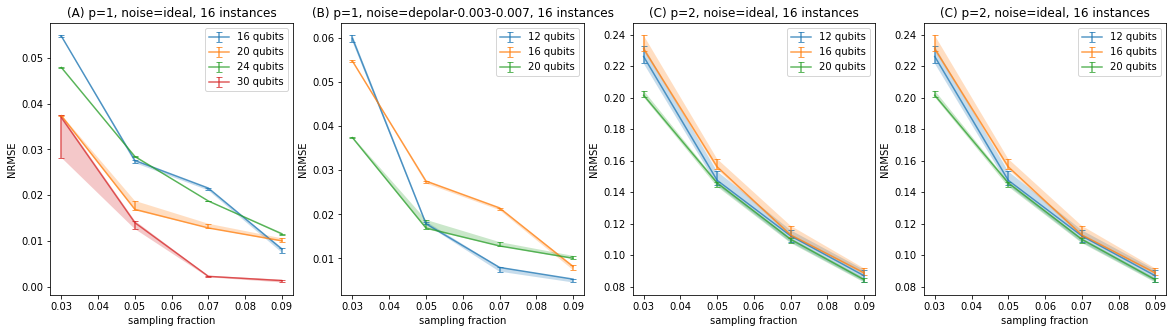

In [79]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Sec4A, ideal, p=1
vis_maxcut(axes[0], p=1, noise="ideal", error_type="NRMSE")

# Sec4B, noisy, p=1
vis_maxcut(axes[1], p=1, noise="depolar-0.003-0.007", error_type="NRMSE")

# Sec4C, ideal, p=2
vis_maxcut(axes[2], p=2, noise="ideal", error_type="NRMSE")

# should be Sec4D, ideal, p=2
vis_maxcut(axes[3], p=2, noise="ideal", error_type="NRMSE")

for ax in axes:
    ax.legend()

plt.savefig("paper_figs/recon_error_ABCD.svg", bbox_inches="tight")
plt.show()


shape before transpose:  (3, 16, 5)
shape after transpose:  (3, 5, 16)
[[0.05909258 0.01770337 0.00701663 0.00457048]
 [0.05986495 0.01785539 0.00797331 0.00532327]
 [0.0605495  0.01837359 0.00808095 0.00533173]]
[0.03 0.05 0.07 0.09]
[[0.05457475 0.02700772 0.0209682  0.00739232]
 [0.05469399 0.02754018 0.02146561 0.00817456]
 [0.05496666 0.02762873 0.02150486 0.00846415]]
[0.03 0.05 0.07 0.09]
[[0.03721728 0.01666049 0.01277065 0.00987133]
 [0.03737256 0.01689937 0.01283615 0.01005242]
 [0.03760373 0.01875596 0.01372232 0.01059043]]
[0.03 0.05 0.07 0.09]


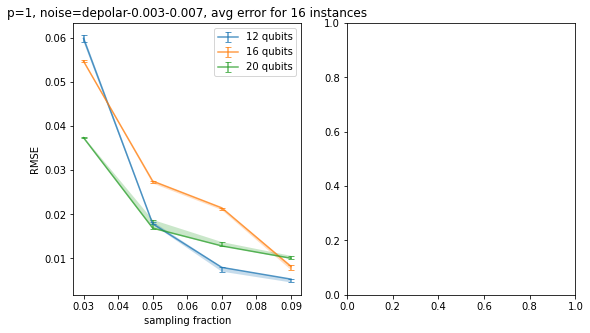

In [56]:

# Sec4B, noisy, p=1
vis_maxcut(p=1, noise="depolar-0.003-0.007", error_type="MSE")


shape before transpose:  (3, 16, 5)
shape after transpose:  (3, 5, 16)
[[0.22167901 0.14442705 0.10824872 0.08329361]
 [0.22607619 0.1475172  0.11225532 0.08693761]
 [0.23259903 0.1532211  0.11583363 0.09065866]]
[0.03 0.05 0.07 0.09]
[[0.22952322 0.15443741 0.11182057 0.08767584]
 [0.23095735 0.15609139 0.11287206 0.08876138]
 [0.23948098 0.16109835 0.11867396 0.09160117]]
[0.03 0.05 0.07 0.09]
[[0.20028259 0.14349471 0.10772596 0.08272283]
 [0.2015053  0.14584432 0.11008189 0.08444858]
 [0.20446774 0.14675618 0.11087133 0.08548086]]
[0.03 0.05 0.07 0.09]


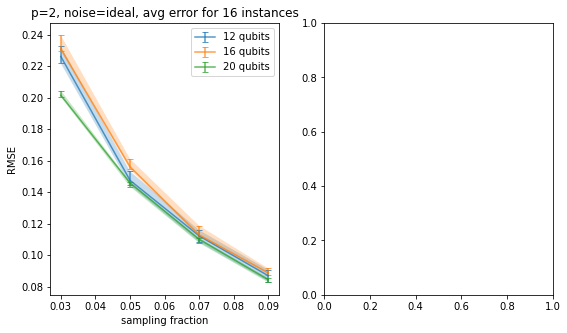

In [54]:

# Sec4C, ideal, p=2
vis_maxcut(p=2, noise="ideal", error_type="MSE")


In [55]:

# Sec4D, noise-2, p=2
vis_maxcut(p=2, noise="depolar-0.003-0.007", error_type="MSE")

    

ValueError: 

In [37]:
def vis_recon_error_old(nq_range, inst_range, sf_range, errors, start=1):

    errors = errors.reshape(len(nq_range), len(inst_range), len(sf_range))
    print("shape before transpose: ", errors.shape)
    # print(errors)
    # errors = errors.transpose(0, 2, 1)
    # print("shape after transpose: ", errors.shape)
    fig = plt.figure(figsize=[10, 8])
    # plt.plot()
    ax = plt.axes()
    for i in range(len(nq_range)):
        for j in range(len(inst_range)):
            # print(sf_range[2:])
            ax.plot(sf_range[start:], errors[i,j,start:], label=f"{nq_range[i]} qubits, {inst_range[j]}-th inst")
    # plt.plot(beta_opt, gamma_opt, "ro")

    # X, Y = np.meshgrid(sr_range, sf_range, indexing='ij')
    # Z = errors.reshape(len(sr_range), len(sf_range))

    # c = ax.pcolormesh(X, Y, Z) # , cmap='viridis', vmin=z_min, vmax=z_max)
    # ax.axis([X.min(), X.max(), Y.min(), Y.max()])

    ax.set_xlabel("sampling fraction")
    # ax.set_xticks(sr_range)
    ax.set_ylabel("MSE")
    # ax.set_yticks(sf_range)
    ax.set_title("MSE, depolarizing, beta_step=50")
    plt.legend()
    # ax.plot(beta_opt, gamma_opt, "ro")
    # fig.colorbar(c, ax=ax)
    # fig.savefig(figpath)
    plt.show()
    return errors

def vis_maxcut(p: int, noise: str, error_type: str):
    if p == 1 and noise == 'ideal':
        recon_error_data = np.load(
            "figs/grid_search_recon/maxcut/sv-ideal-p=1/recon_error_ns=[16, 20, 24, 30]-seeds=[0, 1, 2, 3, 4, 5, 6, 7]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            , allow_pickle=True
        )
        nq_range = [16, 20, 24, 30]
        inst_range = list(range(8))
    elif p == 1 and noise == 'depolar-0.003-0.007':
        recon_error_data = np.load(
            "figs/grid_search_recon/maxcut/sv-depolar-0.003-0.007-p=1/recon_error_ns=[12, 16, 20]-seeds=[0, 1, 2, 3, 4, 5, 6, 7]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
            , allow_pickle=True
        )
        nq_range = [12, 16, 20]
        inst_range = list(range(8))
    else:
        raise ValueError()

    # if noise == 'depolar-0.001-0.005':
    #     # depolarizing 0.001, 0.005
    #     mse = [0.5294567889697064, 0.10504512962369626, 0.0313981299420259, 0.012503321574744162, 0.008140374429632507, 0.8424334405179074, 0.10568723568802518, 0.03212506658687189, 0.014080103905186459, 0.009296142398008756, 0.526865075200324, 0.12747919612932213, 0.06309042154958099, 0.049028926963782395, 0.017344741404916143, 0.5292877712080678, 0.12807155118871388, 0.06338557278944737, 0.04927365907019386, 0.01742941715973452, 1.9361662554992944, 0.11117192831199525, 0.05794935815783304, 0.042218665732938074, 0.031913622196141994, 1.9274262480485385, 0.11380618083255489, 0.06048147435362607, 0.042544439403038134, 0.032231339880888894]
    #     cos = [0.03345611343649668, 0.001882758932071349, 0.00018351884817768838, 3.2312424903535586e-05, 1.3707400878582021e-05, 0.1189645214978915, 0.00180777477491334, 0.0001907390154839428, 4.040555030127013e-05, 1.7545841520250072e-05, 0.023844061448096587, 0.002032726517411043, 0.0004999788199564481, 0.00030430659574010033, 3.7662019811590675e-05, 0.02382890847269281, 0.0020325601979672703, 0.0004999731174260003, 0.0003044908765591492, 3.767714656655041e-05, 0.3036874338519604, 0.0008274828744364582, 0.0002466740593143335, 0.0001358167458470616, 7.858596328635947e-05, 0.29930637856623044, 0.0008437189310439575, 0.0002633779178375928, 0.0001353103607633077, 7.849847216112593e-05]
        
    # elif noise == 'depolar-0.003-0.007':
    #     mse = [0.5039391145820539, 0.10187541579824788, 0.030521028927380053, 0.012100274958501474, 0.007879699198447391, 0.8164015928099697, 0.10280057365192978, 0.031246832290654097, 0.013655930917672875, 0.00904611410285615, 0.5111357466189159, 0.12415765730594497, 0.06143917804136556, 0.047700887403396286, 0.016817643074515512, 0.5106162502837763, 0.12448309263267172, 0.06159363454853711, 0.047782653207815724, 0.016818108440983092, 1.8821332493158773, 0.10812472566677976, 0.05626310971617496, 0.040952219495018434, 0.030904712822065413, 1.8743446567979802, 0.11086259352599241, 0.05872780804047352, 0.04143577374538176, 0.031403123343349756]
    #     cos = [0.03136409094172088, 0.0018815084299171891, 0.00018399240948696605, 3.213134121327066e-05, 1.364762014444132e-05, 0.11782864549589178, 0.0018098338121567137, 0.00019087352646751654, 4.0206323897673535e-05, 1.7577098521237566e-05, 0.02374738664478715, 0.002033384390250359, 0.000500005455133401, 0.00030376060436587693, 3.733602140165715e-05, 0.023632971680983994, 0.0020339993226150543, 0.0005000360258804459, 0.00030330285893775955, 3.7151272810787006e-05, 0.30499961591915303, 0.0008297448762913939, 0.00024676532028444775, 0.00013542860375459487, 7.80946002396643e-05, 0.2968800883830971, 0.0008426220675257223, 0.00026143955952540043, 0.00013512567448970003, 7.84428741792409e-05]
    # else:
    #     raise NotImplementedError()

    if error_type == 'MSE':
        errors = recon_error_data['mses']
    elif error_type == 'COS':
        errors = recon_error_data['coss'] 
    else:
        raise NotImplementedError()

    sf_range = np.arange(0.01, 0.11, 0.02)
    # errors_noisy = vis_recon_error_p1(nq_range, inst_range, sf_range, np.array(errors))
    errors_noisy = vis_box_plot(nq_range, inst_range, sf_range, np.array(errors))

plot_error("depolar-0.001-0.005", "MSE")
plot_error("depolar-0.003-0.007", "COS")

    

TypeError: plot_error() missing 1 required positional argument: 'error_type'

In [ ]:
# ideal, recon error

mse = [0.5565766581873556, 0.13437769973619176, 0.0665126187210659, 0.05173366713103397, 0.018353605365084492, 0.5565766581873564, 0.13437769973619085, 0.0665126187210705, 0.05173366713103232, 0.018353605365095765, 0.682825558610413, 0.13436982692393828, 0.06771727263453953, 0.05290551293891448, 0.020181597010536727, 2.029227178397665, 0.11642660067801282, 0.060800852770935145, 0.044341175517035925, 0.03348434250303546, 2.0281716542777444, 0.1196496159743286, 0.06381786828961503, 0.04465772552423436, 0.0338759429431382, 2.0292271783976656, 0.11642660067801273, 0.060800852770934756, 0.04434117551703168, 0.03348434250302957, 0.7811725565489757, 0.17756207745900035, 0.10550643279176339, 0.06928139310076305, 0.04292071947529103, 1.0896285401626504, 0.17873801113689375, 0.10537584283381209, 0.06966475606687052, 0.043160056088815305, 0.4635234362873778, 0.14353502668475, 0.08427835200777564, 0.06669484054414562, 0.0414705455723753, 0.8866598378767956, 0.1725787043917337, 0.0645506992899331, 0.010478228635834533, 0.006176225731408726, 1.1068471367355863, 0.17071470648289172, 0.06657052809749948, 0.010978833158495228, 0.007215821376888723, 1.1068471367355976, 0.1707147064829075, 0.06657052809749567, 0.010978833158501159, 0.007215821376886939]
cos = [0.02393922161288986, 0.002031606312861367, 0.0004998125049687774, 0.00030476000060497555, 3.79319452308291e-05, 0.02393922161288975, 0.002031606312861478, 0.0004998125049689994, 0.0003047600006051976, 3.7931945231051145e-05, 0.036562052853848614, 0.0019962271792863806, 0.0005100434114092556, 0.00031427900251856933, 4.5381234023311734e-05, 0.30298364798410826, 0.0008244283731778657, 0.00024676555660385624, 0.00013625217729096306, 7.868483674555726e-05, 0.30174074270188933, 0.0008457772434531385, 0.00026585457433536686, 0.0001351682739886284, 7.861509642415054e-05, 0.3029836479841084, 0.0008244283731778657, 0.0002467655566040783, 0.00013625217729107408, 7.868483674544624e-05, 0.02138526815999564, 0.0013933410189659323, 0.0005435088913930963, 0.00023855821507523522, 9.208463972287806e-05, 0.04468944716383838, 0.0013721218090904097, 0.0005333604725971108, 0.00023836158472689828, 9.200612198623226e-05, 0.006355165400067975, 0.0009692026592464931, 0.0003517273108397667, 0.00022428604096047522, 8.678210358059602e-05, 0.015555523348037337, 0.0007856194744289002, 0.0001262640961463557, 3.397591558429447e-06, 1.2065216363765785e-06, 0.026571657214737088, 0.0007513541621994024, 0.00013321254320652898, 3.715799604009362e-06, 1.6273890477425113e-06, 0.026571657214737865, 0.0007513541621996245, 0.00013321254320652898, 3.7157996037873176e-06, 1.627389047631489e-06]
nq_range = [16, 20, 24, 30]
inst_range = [0, 1, 2]
sf_range = np.arange(0.01, 0.11, 0.02)
errors_ideal = vis_recon_error_p1(nq_range, inst_range, sf_range, np.array(mse))
# errors_ideal = vis_recon_error_p1(nq_range, inst_range, sf_range, np.array(cos))
    

In [ ]:
def compare_p1_recon_ideal_and_noisy(sf_range, es_ideals, es_noisys, start=1):
    seeds = [0, 1]
    nQs = [16, 20] # intersect of ideal and noisy data
    print(es_ideals.shape)
    print(es_noisys.shape)

    for i in range(len(nQs)):
        for j in range(len(seeds)):
            es_ideal = es_ideals[i, j, start:] # 16, 20, 24, 30
            es_noisy = es_noisys[i + 1, j, start:] # 12, 16, 20

            fig = plt.figure(figsize=[6, 4])
            ax = plt.axes()
            ax.plot(sf_range[start:], es_ideal, label=f"ideal, {nq_range[i]} qubits, {inst_range[j]}-th inst")
            ax.plot(sf_range[start:], es_noisy, label=f"noisy, {nq_range[i]} qubits, {inst_range[j]}-th inst")
            ax.set_xlabel("sampling fraction")
            ax.set_ylabel("MSE")
            ax.set_title("MSE, compare, beta_step=50")
            plt.legend()
            plt.show()
        
    return
compare_p1_recon_ideal_and_noisy(sf_range, es_ideals=errors_ideal, es_noisys=errors_noisy)

In [ ]:
mse =  [2.5098071285543138, 1.6552018198271319, 1.093384378156003, 0.8044046488875147, 0.6273614828069227]
cos =  [0.18824535005095422, 0.07806253240573047, 0.03269121889389315, 0.017541222786266242, 0.010653914431462241]

nq_range = [24]
inst_range = [0]
sf_range = np.arange(0.01, 0.11, 0.02)
# errors_p2 = vis_recon_error_p1(nq_range, inst_range, sf_range, np.array(mse), 0)
errors_p2 = vis_recon_error_p1(nq_range, inst_range, sf_range, np.array(cos), 0)

shape before transpose:  (4, 1, 5)
shape after transpose:  (4, 5, 1)


UnboundLocalError: local variable 'y' referenced before assignment

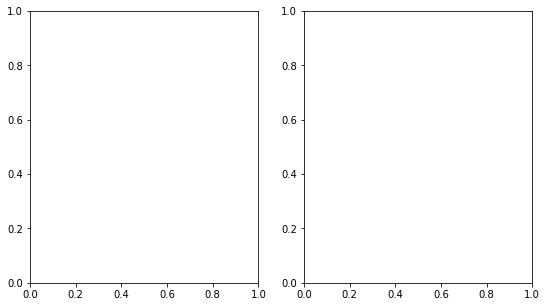

In [19]:

def vis_partition():
    recon_error_data = np.load(
        "figs/grid_search_recon/partition/sv-ideal-p=1/recon_error_ns=[12, 16, 20, 24]-seeds=[0]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
        # "figs/grid_search_recon/partition/sv-ideal-p=2/recon_error_ns=[12, 16]-seeds=[0]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
        , allow_pickle=True
    )
    nq_range = [12, 16, 20, 24]
    inst_range = [0]
    sf_range = np.arange(0.01, 0.11, 0.02)
    mses = recon_error_data['mses']
    coss = recon_error_data['coss']
    vis_recon_error(nq_range, inst_range, sf_range, mses, "quantiles", "partition, p=1")
    
vis_partition()

shape before transpose:  (4, 1, 5)
shape after transpose:  (4, 5, 1)


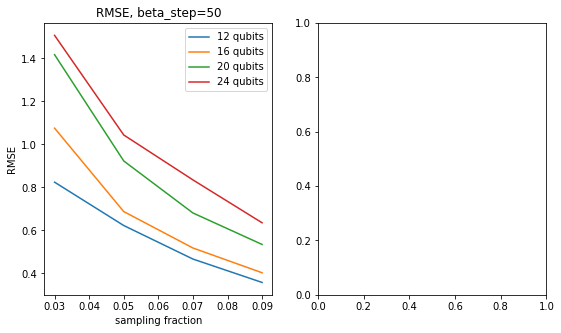

In [ ]:

def vis_sk_model():
    recon_error_data = np.load(
        "figs/grid_search_recon/skmodel/sv-ideal-p=2/recon_error_ns=[12, 16, 20, 24]-seeds=[0]-sfs=[0.01 0.03 0.05 0.07 0.09].npz"
        , allow_pickle=True
    )
    nq_range = [12, 16, 20, 24]
    inst_range = [0]
    sf_range = np.arange(0.01, 0.11, 0.02)
    mses = recon_error_data['mses']
    coss = recon_error_data['coss']
    vis_recon_error(nq_range, inst_range, sf_range, mses, "line", "SK Model")
    
vis_sk_model()